# VGG16 :  Images - Iteration #6 : Data Augementation & Fine Tuning

img_rows = 224 <br>
img_cols = 224 <br>
batch_size =  64 <br>
epochs = 100 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
Data augmentation <br>
unfreezing of the last  base model layers <br> 
Fitting with supposed optimal LR : 0.0006  <br>

**<u>Results</u>**

Accuracy : 0.?? <br>
F1 score weighted : 0.??

**Import packages**

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #6 -  VGG16

***Read DataFrame from saved pickele file - image Train set***

In [2]:
#Load df of images already resized on 256 x 256 
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_ORG_im_size_23112021.pkl")

In [3]:
df_train_im

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,resized_image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,resized_image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,resized_image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,resized_image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,resized_image_1077757786_product_278535884.jpg
...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,40,resized_image_941495734_product_206719094.jpg
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,2583,resized_image_1188462883_product_3065095706.jpg
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,2280,resized_image_1009325617_product_440707564.jpg
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,1560,resized_image_1267353403_product_3942400296.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [5]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [6]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [7]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [8]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [9]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [10]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [11]:
# Split Train set 
X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [12]:
display(X_train_im.shape)
display(X_test_im.shape)

(67932, 6)

(16984, 6)

***Data Generator***

In [13]:
img_rows = 224
img_cols = 224
batch_size = 64
epochs = 100
images_dir_train = './data/images/all/image_train_resized/'
#images_dir_test = './data/images/all/image_test_resized/'

In [14]:
%%time
#Générateur de données
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  shear_range=0.2,
                                  rotation_range = 45,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True
                                  #validation_split = 0.2
                                  )

Wall time: 0 ns


In [15]:
%%time
valid_datagen = ImageDataGenerator(rescale=1./255)

Wall time: 0 ns


In [16]:
%%time

#Itérateur 
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True  # défault
                                              #subset = 'training'
                                             )

Found 67932 validated image filenames belonging to 27 classes.
Wall time: 6.33 s


In [17]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = valid_datagen.flow_from_dataframe(dataframe = X_test_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False
                                              #subset  = 'validation'
                                             )

Found 16984 validated image filenames belonging to 27 classes.
Wall time: 1.39 s


 ***VGG16 Implementation - with fine tuning***

In [18]:
%%time
# Freez des chouche pré_entrainées d'Extraction de Features
base_model = VGG16(weights='imagenet', include_top = False, input_shape = (img_rows,img_rows,3))
for layer in base_model.layers:
    layer.trainable = False

Wall time: 4.9 s


***Unfreeze the last 8 layers of the base_model***

In [19]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [20]:
# Architecture VGG16
model = Sequential()

# Ajout du modèle VGG16
model.add(base_model) 

# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 27, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1

In [21]:
#for layer in model.layers:
 #   print(layer.name, "  " , layer.trainable)

In [22]:
print("[INFO] VGG16 base model length :  ", len(base_model.layers))
print("[INFO] Constructed model length : ", len(model.layers))

print('\nLast the last ten layers base model - VGG16: \n ')  
for layer in base_model.layers[-10:]:
    print("                 ", layer.name, "  " , layer.trainable)
    
print('\n Layers of built model: \n')  
for layer in model.layers:
    print("                 ", layer.name, "  " , layer.trainable)

[INFO] VGG16 base model length :   19
[INFO] Constructed model length :  7

Last the last ten layers base model - VGG16: 
 
                  block3_conv3    False
                  block3_pool    False
                  block4_conv1    True
                  block4_conv2    True
                  block4_conv3    True
                  block4_pool    True
                  block5_conv1    True
                  block5_conv2    True
                  block5_conv3    True
                  block5_pool    True

 Layers of built model: 

                  vgg16    True
                  global_average_pooling2d    True
                  dense    True
                  dropout    True
                  dense_1    True
                  dropout_1    True
                  dense_2    True


***Callbacks***

In [23]:
# For saving Callbacks and history results
path = './saves/VGG16/Iteration_6/'
date_result = '16012022'
nbr_Epochs = epochs

In [25]:
%%time

file_name = 'checkpoint_VGG16_' + date_result + '_' + str(nbr_Epochs)+ 'Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 10, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

#Réduire automatiquement le learning rate :
lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                               patience = 10,
                               verbose = 1,
                                mode='min'
                               )

Wall time: 0 ns


 ***Model Compilation***

In [26]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate=  0.0006) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

Wall time: 1.65 s


 ***Fit - train_generator***

In [27]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [28]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks=[checkpoint, early]                    
                    )

Epoch 1/100
1061/1061 [==============================] - 697s 642ms/step - loss: 2.6556 - accuracy: 0.2170 - val_loss: 2.2928 - val_accuracy: 0.3192

Epoch 00001: val_accuracy improved from -inf to 0.31922, saving model to ./saves/VGG16/Iteration_6\checkpoint_VGG16_16012022_100Epochs.h5
Epoch 2/100
1061/1061 [==============================] - 588s 554ms/step - loss: 2.2328 - accuracy: 0.3426 - val_loss: 2.1098 - val_accuracy: 0.3791

Epoch 00002: val_accuracy improved from 0.31922 to 0.37907, saving model to ./saves/VGG16/Iteration_6\checkpoint_VGG16_16012022_100Epochs.h5
Epoch 3/100
1061/1061 [==============================] - 592s 558ms/step - loss: 2.0815 - accuracy: 0.3864 - val_loss: 1.9910 - val_accuracy: 0.4106

Epoch 00003: val_accuracy improved from 0.37907 to 0.41055, saving model to ./saves/VGG16/Iteration_6\checkpoint_VGG16_16012022_100Epochs.h5
Epoch 4/100
1061/1061 [==============================] - 585s 551ms/step - loss: 1.9885 - accuracy: 0.4126 - val_loss: 1.8978 - va

1061/1061 [==============================] - 582s 548ms/step - loss: 1.5807 - accuracy: 0.5216 - val_loss: 1.6241 - val_accuracy: 0.5193

Epoch 00034: val_accuracy did not improve from 0.52264
Epoch 35/100
1061/1061 [==============================] - 582s 549ms/step - loss: 1.5796 - accuracy: 0.5229 - val_loss: 1.6244 - val_accuracy: 0.5207

Epoch 00035: val_accuracy did not improve from 0.52264
Epoch 36/100
1061/1061 [==============================] - 583s 549ms/step - loss: 1.5872 - accuracy: 0.5194 - val_loss: 1.6314 - val_accuracy: 0.5172

Epoch 00036: val_accuracy did not improve from 0.52264
Epoch 37/100
1061/1061 [==============================] - 581s 548ms/step - loss: 1.5735 - accuracy: 0.5230 - val_loss: 1.6315 - val_accuracy: 0.5130

Epoch 00037: val_accuracy did not improve from 0.52264
Epoch 38/100
1061/1061 [==============================] - 581s 547ms/step - loss: 1.5682 - accuracy: 0.5259 - val_loss: 1.6389 - val_accuracy: 0.5163

Epoch 00038: val_accuracy did not impr



***Save  results***

In [29]:
filename = 'history_VGG16_all_train'+ date_result + '_Shape_299x299_'+ str(nbr_Epochs) +'Epochs'

In [30]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

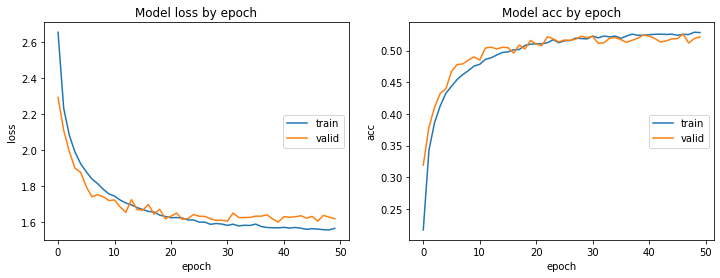

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Prediction - valid_generator***

In [32]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from valid generator
y_true = valid_generator.classes

Wall time: 29.8 s


 ***Evaluation - valid_generator***

In [33]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)

print("Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("Loss: ",valid_score[0])

266/266 [==============================] - 29s 106ms/step - loss: 1.5982 - accuracy: 0.5247
Accuracy: 52.47%
Loss:  1.5982117652893066
Wall time: 28.6 s


In [34]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)

f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)

f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.4311208598818575
[INFO] f1 score micro average:  0.5246702779086199
[INFO] f1 score weighted average:  0.4996930703680058


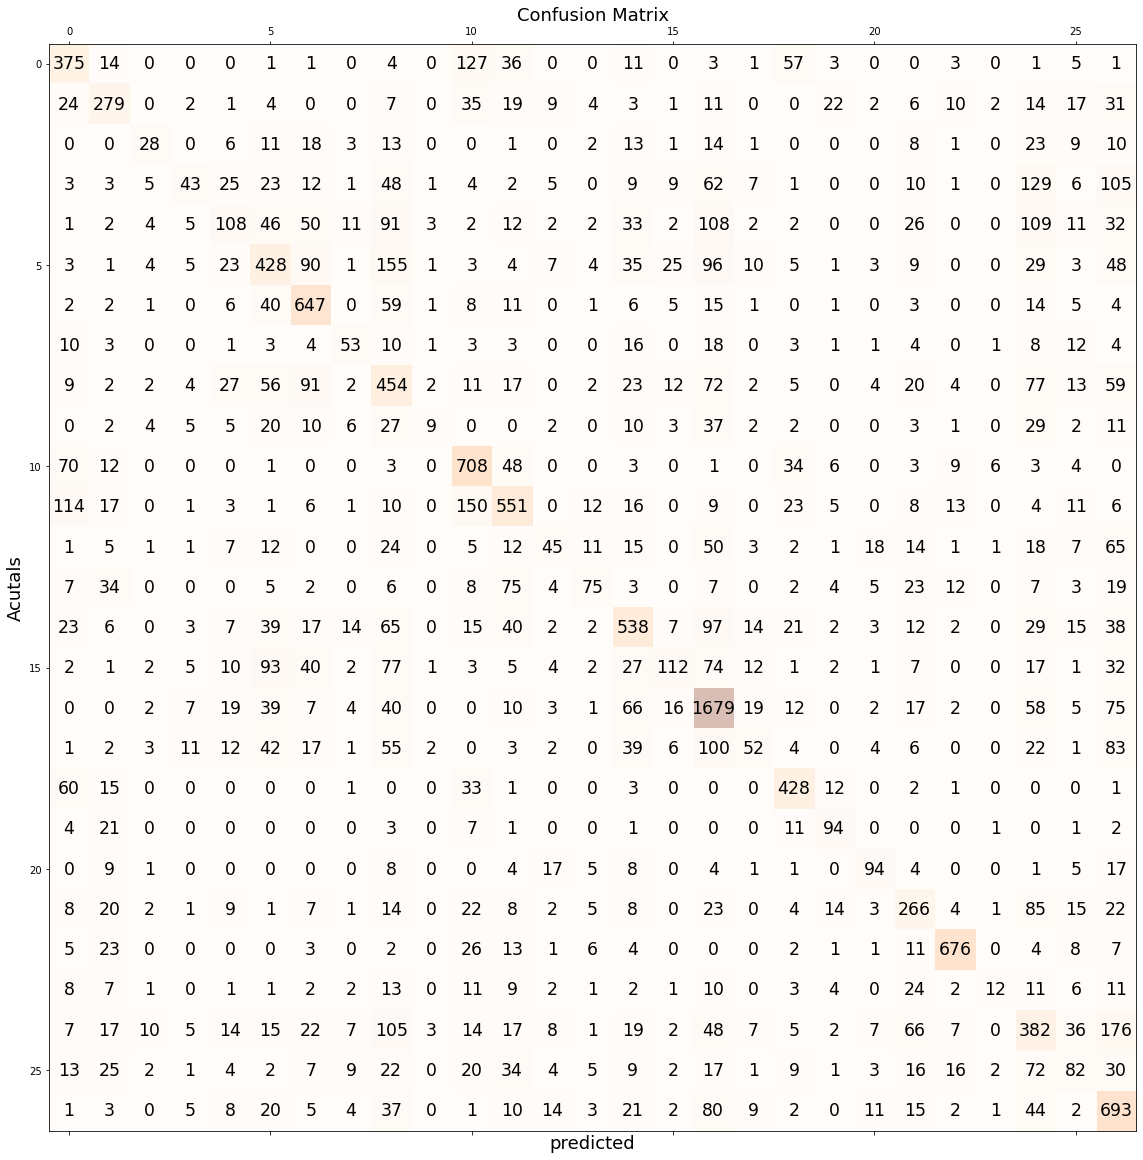

In [35]:
#Confusion matrix
matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

In [37]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       643
           1       0.53      0.55      0.54       503
           2       0.39      0.17      0.24       162
           3       0.41      0.08      0.14       514
           4       0.36      0.16      0.23       664
           5       0.47      0.43      0.45       993
           6       0.61      0.78      0.68       832
           7       0.43      0.33      0.38       159
           8       0.34      0.47      0.39       970
           9       0.38      0.05      0.08       190
          10       0.58      0.78      0.67       911
          11       0.58      0.57      0.58       961
          12       0.34      0.14      0.20       319
          13       0.52      0.25      0.34       301
          14       0.57      0.53      0.55      1011
          15       0.54      0.21      0.30       533
          16       0.64      0.81      0.71      2083
          17       0.36    

 ***Predict input image using trained model***

In [ ]:
# Predict With Pre Trained

# Load an image
im_id = 27
img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(128, 128))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [ ]:
im = cv2.resize(cv2.imread(img_path), (224, 224))
im = np.expand_dims(im, axis=0)

In [ ]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False))


 ***Save VGG16 Model***

In [38]:
#Enregistrement du modèle :
model.save(path + 'Model_VGG16_All_Train_data_' +  date_result +  '_'+ str(nbr_Epochs) + 'Epochs.hdf5')
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load VGG16 Model***

In [ ]:
#Rechargement du modèle :
#model = load_model("hdf5 file path")